In [1]:
import torch 
import torch.nn as nn
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
from sklearn.datasets import make_regression,make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
#custom dataset

class CustDat(torch.utils.data.Dataset):
    def __init__(self,df,target):
        self.df = df 
        self.target = target
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self,idx):
        dp = self.df.iloc[idx].values
        targ = self.target[idx]
        
        dp = torch.from_numpy(dp).float()
        targ = torch.tensor(targ).float()

        return dp,targ

In [4]:
# model 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Linear(10,20)
        self.layer2 = nn.Linear(20,20)
        self.layer3= nn.Linear(20,1)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()
        
        
    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x= self.relu(x)
        x=self.layer3(x)
        x=self.relu(x)
        x = self.sig(x)
        
        return x

In [5]:
train, target = make_classification(n_samples = 5000, n_features = 10 ,n_informative =8,
                                    random_state = 1, n_classes=2 )
train = pd.DataFrame(train)

train_x, test_x , train_y, test_y = train_test_split(train,target,
                                                     test_size=0.1,
                                                     random_state=1234)

train_dl = torch.utils.data.DataLoader(CustDat(train_x,train_y),
                                batch_size = 265,
                                shuffle = True,
                                num_workers=0 ,
                                pin_memory = True, #false is cpu 
                                )



val_dl = torch.utils.data.DataLoader(CustDat(test_x,test_y),
                                batch_size = 265,
                                shuffle = True,
                                num_workers=0 ,
                                pin_memory = True, #false is cpu 
                                )

In [6]:
next(iter(train_dl))

[tensor([[-0.2524, -0.0612,  1.5737,  ...,  0.8996,  1.8677,  0.0193],
         [-3.2803, -2.3132,  1.5804,  ..., -1.1475,  0.5849,  3.9322],
         [ 2.5372, -2.6728,  0.3836,  ..., -1.7896, -1.0619, -2.6930],
         ...,
         [-1.1596,  4.1251, -1.6627,  ..., -1.3249, -2.7631, -4.1500],
         [ 1.7844,  0.3930, -2.6055,  ..., -0.1527,  0.8033,  3.0325],
         [-1.6146,  1.8432,  0.4689,  ..., -0.7656, -2.0682, -4.1592]]),
 tensor([0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
         1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
         1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,

In [7]:
model = Net()
model.to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [8]:
print(model)

Net(
  (layer1): Linear(in_features=10, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
  (sig): Sigmoid()
)


In [9]:
# training loop 


num_epochs = 100
train_loss = []
test_loss = []
print('epoch        | train_epoch_loss | test_epoch_loss   ')

# Create a tqdm progress bar outside the loop
#progress_bar = tqdm(total=num_epochs, desc='Training Progress')


for epoch in range(num_epochs):
    train_epoch_loss = 0
    test_epoch_loss = 0
    for data,target in train_dl:
        data = data.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)   
        
        output = model(data)
        loss = loss_fn(output.squeeze(), target)
        train_epoch_loss =+ loss.detach().cpu().numpy()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # no need for no_grad() we're not training to we'll not
        # used backprop so there is no need for the backward graph
    with torch.no_grad():
         for data,target in val_dl:
                data = data.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True) 
                output = model(data)
                loss = loss_fn(output.squeeze(),target)
                # no point of writing .detach() here since we're not working 
                # with computational graphs in the test phase
                test_epoch_loss += loss.detach().cpu().numpy()
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    
    #progress_bar.set_postfix({'train_loss': train_epoch_loss, 'test_loss': test_epoch_loss})
    #progress_bar.update(1)
    if epoch % 10 ==0:
        print(f' {epoch:10} | {train_epoch_loss:16.4f} |  {test_epoch_loss:16.4f}')
    
#progress_bar.close()
    

epoch        | train_epoch_loss | test_epoch_loss   
          0 |           0.6927 |            1.3859
         10 |           0.6756 |            1.3573
         20 |           0.6505 |            1.3004
         30 |           0.6021 |            1.2123
         40 |           0.5488 |            1.1142
         50 |           0.5573 |            1.0337
         60 |           0.5206 |            0.9763
         70 |           0.4782 |            0.9458
         80 |           0.4863 |            0.9199
         90 |           0.4763 |            0.9080


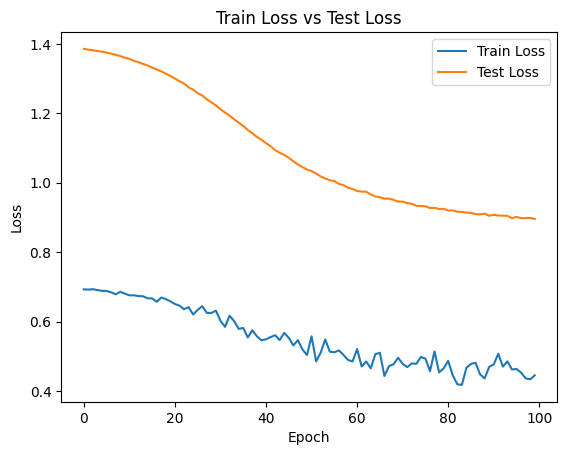

In [10]:
# Plot train loss and test loss
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

# Customize plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Test Loss')
plt.legend()

# Display the plot
plt.show()